# The discovery of dark energy

## a project in Bayesian methods in cosmology 

Plan for the project:
    1. Understanding the supernovae data and the dark energy measurement problem
    2. Writing an MCMC sampler
    3. Plotting constraints on dark energy 
    4. Understanding the ABC method
    5. Constraining cosmology using the ABC method
    

## 1. Introduction

Today we want to infer the dark energy vs matter density in the universe today from super nova type Ia data published by the SNLS team (http://cfht.hawaii.edu/SNLS/, http://arxiv.org/abs/1104.1443). Super nova of type Ia are standard candles, meaning that their intrinsic luminosity is always roughly the same. The following plot shows all supernova magnitudes contained in the SNLS catalog as a function of redshift.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
%matplotlib inline
import sys
sys.path.append('scripts')

In [2]:
from SNLSLikelihoodModule import SNLSLikelihoodModule

In [3]:
likelihood = SNLSLikelihoodModule("C:\\Users\\tachy\\Desktop\\eth\\stamet\\STAMET_project\\data\\")

C:\Users\tachy\Desktop\eth\stamet\STAMET_project\data\SNLSLikelihoodModule.py:26: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  lcdparams = genfromtxt(snlsdata_path+'snls_3rdyear_lcparams.txt', names = True, dtype=None)


Text(0.5,1,'SNLS dataset')

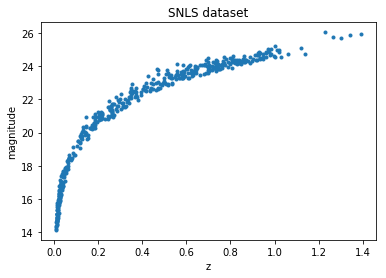

In [58]:
plt.plot(likelihood.lcdparams['zcmb'], likelihood.lcdparams['mb'], '.')
plt.xlabel('z')
plt.ylabel('magnitude')
plt.title('SNLS dataset')

We know that the observed flux $F$ as a function of redshift $z$ and intrinsic luminosity $L$ is given by

$$F(z, L) = \frac L {4\pi d_L(z)^2}$$

with $d_L(z)$ being the luminosity distance to a redshift $z$ which depends on the background cosmology of our universe. By measuring the luminosity of super nova as a function of redshift one can therefore learn about the expansion history of our universe. The following plot shows the luminosity distance for a $\Lambda CDM$ universe with a matter density today of $\Omega_m = 0.3$:

[]

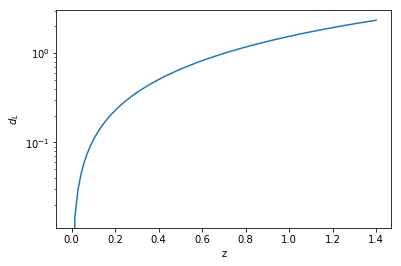

In [59]:
z = np.linspace(0, 1.4, 100)
dL = likelihood.getLCDMLuminosityDistance(z, 0.3)
plt.plot(z, dL)
plt.xlabel('z')
plt.ylabel('$d_L$')
plt.semilogy()

## 2. Understand the SNLSLikelihoodModule

In the repository you can find a simplistic implementation of the likelihood of the SNLS dataset which depends on four parameters: The matter density in the universe today $\Omega_m$, a stretch parameter $\alpha$, a color parameter $\beta$, and an absolute magnitude parameter $M$. While the first one is a parameter of cosmological interest, the other three parameters are so-called nuisance parameters which are needed for modelling the data. Find out how to plot the model magnitude along with the SNLS data and errorbars on the SNLS data given the parameters $\Omega_m = 0.3$, $\alpha = 1.0, \beta = 2.0$, and $M = 24$.

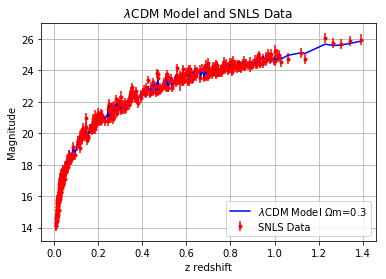

0.023172399886166165


(array([ 1.,  0.,  0.,  0.,  0.,  2.,  1.,  0.,  1.,  2.,  3.,  3.,  4.,
         2.,  1.,  5.,  3.,  5.,  6., 12., 11., 13.,  8., 20., 18., 21.,
        26., 34., 23., 30., 30., 41., 23., 26., 27., 12.,  8.,  9., 11.,
         2.,  5.,  6.,  5.,  4.,  3.,  1.,  1.,  1.,  1.,  1.]),
 array([-0.61788392, -0.5969801 , -0.57607629, -0.55517247, -0.53426866,
        -0.51336484, -0.49246103, -0.47155721, -0.4506534 , -0.42974958,
        -0.40884577, -0.38794195, -0.36703814, -0.34613432, -0.32523051,
        -0.30432669, -0.28342288, -0.26251906, -0.24161525, -0.22071144,
        -0.19980762, -0.17890381, -0.15799999, -0.13709618, -0.11619236,
        -0.09528855, -0.07438473, -0.05348092, -0.0325771 , -0.01167329,
         0.00923053,  0.03013434,  0.05103816,  0.07194197,  0.09284579,
         0.1137496 ,  0.13465342,  0.15555723,  0.17646105,  0.19736486,
         0.21826868,  0.23917249,  0.26007631,  0.28098012,  0.30188394,
         0.32278775,  0.34369157,  0.36459538,  0.3854992 ,

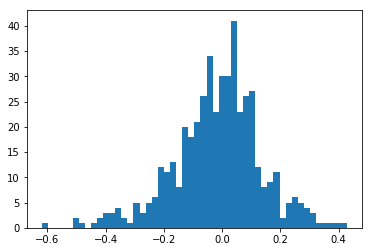

In [41]:
z = likelihood.lcdparams['zcmb']
mmag = likelihood.getModelMag(0.3,1.0,2.0,24)
mag = likelihood.lcdparams['mb']
err_bars = likelihood.getVariance(1.0,2.0)


plt.title('$\lambda$CDM Model and SNLS Data')
plt.plot(z,mmag,color = 'blue',label = '$\lambda$CDM Model $\Omega$m=0.3')
plt.errorbar(z,mag,np.sqrt(err_bars),fmt = 'r.', label = 'SNLS Data')
plt.xlabel('z redshift')
plt.ylabel('Magnitude')
plt.grid()
plt.legend(loc = 'lower right')
plt.show()

devs = mmag-mag

print(np.var(devs))

plt.hist(devs,50)

## 3. Write a Metropolis-Hastings sampler

Write a Metropolis Hastings sampler that takes the likelihood module, an initial position in parameter space, a covariance matrix for a Gaussian proposal distribution, and number of iterations as an argument and returns the sample from the posterior assuming a flat prior on all parameters. Test it with the following minimal likelihood module for a 1d standard normal distribution.

In [61]:
from numpy.random import multivariate_normal, normal, random

class metropolis_hastings(object):
    
    positions = []
    
    def __init__(self, position, cov_mat, n_iter, LogLikelihood):
        #The initial position has to be given in array form even in the 1dim case, e.g. [0.4]
        #LogLikelihood : log likelihood function taken as input
        self.N = np.shape(position)[0]#number of parameters #number of parameters
        self.n_iter = n_iter
        self.positions = [] #get empty array every time
        self.positions.append(position)
        self.number_iterations = n_iter
        self.Loglikelihood =  LogLikelihood
        self.N_accepted = 0
        self.cov_mat = cov_mat
        #fill positions
        for k in range(n_iter):
            #new_position = self.positions[-1] + factor*normal(loc=0.0, scale=1.0, size = self.N)
            new_position = multivariate_normal(mean = self.positions[-1], cov = self.cov_mat)
            if LogLikelihood(new_position) >= LogLikelihood(self.positions[-1]):
                self.positions.append(new_position)
                self.N_accepted += 1
            elif LogLikelihood(new_position) < LogLikelihood(self.positions[-1]):
                choice = random()
                ratio = np.exp(LogLikelihood(new_position) - LogLikelihood(self.positions[-1]))
                if choice < ratio:
                    self.positions.append(new_position)
                    self.N_accepted += 1
                else:
                    self.positions.append(self.positions[-1])
                    #pass
               
    def AddPosition(self, position):
        self.positions.append(position)
    
    def GetLogLikelihood(self, x):
        return  self.LogLikelihood(x)
    
    def GetLastPosition(self):
        return self.positions[-1]
    
    def GetPositions(self): 
        return self.positions
    
    def GetNumberOfPositions(self):
        return len(self.positions)
    
    def GetAcceptedRatio(self):
        return float(self.N_accepted)/(float(self.n_iter))
    
    def GetVariableSample(self,index):
        return [position[index] for position in self.positions]
    
    def GetHisto(self, indices, n_bins, show = True, save = True):
        #plot the histogram of the chosen parameters
        #the indices of the variables to plot have to be given in histogram form, e.g. [0] or [0,3]
        #the number of bins is an integer
        for index in indices:
            to_plot = self.GetVariableSample(index)
            mean = np.mean(to_plot)
            variance = np.var(to_plot)
            coord_max = max(to_plot); coord_min = min(to_plot)
            plt.figure(1)
            n = plt.hist(to_plot, bins = n_bins, histtype = "step")
            plt.title("Metropolis Hastings - Distribution of parameter $\Theta^{" + str(index + 1) + "}$")
            plt.xlabel("$\Theta^{" + str(index + 1) + "}$")
            plt.xlim(coord_min, coord_max + (coord_max - coord_min)/3.5)
            plt.text(coord_max - (coord_max - coord_min)/3.5, max(n[0])*0.9, "Number of entries: " + str(self.GetNumberOfPositions()))
            plt.text(coord_max - (coord_max - coord_min)/3.5, max(n[0])*0.8, "Empirical Mean: " + str(round(mean,3)))
            plt.text(coord_max - (coord_max - coord_min)/3.5, max(n[0])*0.7, "Empirical Variance: " + str(round(variance,3)))
            plt.figure(2)
            plt.title("Performance on $\Theta^{" + str(index + 1) + "}$")
            plt.xlabel("Iteration")
            plt.ylabel("Value")
            plt.plot(np.arange(0,n_trials+1),to_plot)
            plt.plot(np.arange(0,n_trials+1),mean*np.ones(n_trials+1), color = 'black')
            if save:
                plt.savefig(str(index) + ".pdf")
            if show:
                plt.show()
     
    #to avoid writing back on previously used objects
    def __exit__(self):
        #this method does not look like it has a great effect...
        self.N = 0
        self.positions = []
        self.number_iterations = 0
        self.Loglikelihood = None

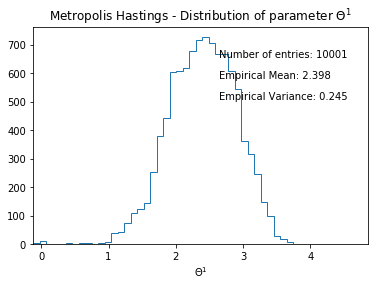

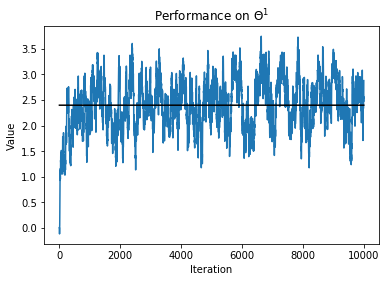

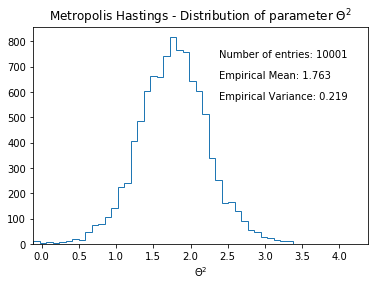

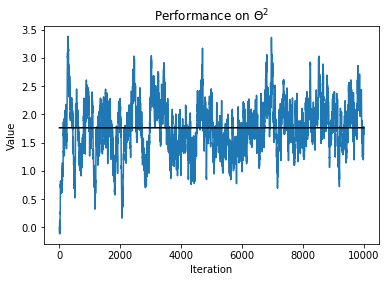

('Fraction of accepted trials: ', 88.66000000000001, '%')


In [62]:
N_exp = 20
mean = [3,2]
std = 2
guess = [0,0]
cov_mat = [[0.01,0],[0,0.01]]
n_trials = 10000

x_meas = normal(loc = mean,scale = std,size = (N_exp,np.shape(mean)[0]))

#Log_gauss = lambda x: sum([-.5*((x[0]-x_meas[k])**2)/(std**2) for k in range(np.shape(x_meas)[0])])
Log_gauss_2D = lambda x: sum([-.5*((x[0]-x_meas[k][0])**2+(x[1]-x_meas[k][1])**2)/(std**2) for k in range(np.shape(x_meas)[0])])
#try_with_gauss = metropolis_hastings(guess, cov_mat, n_trials , Log_gauss)
try_with_gauss_2D = metropolis_hastings(guess, cov_mat, n_trials, Log_gauss_2D)

#try_with_gauss.GetHisto([0], 40, show = True, save = True)
#print("Fraction of accepted trials: ", 100.0*try_with_gauss.GetAcceptedRatio(), "%")


try_with_gauss_2D.GetHisto([0], 40, show = True, save = True)
try_with_gauss_2D.GetHisto([1], 40, show = True, save = True)
print("Fraction of accepted trials: ", 100.0*try_with_gauss_2D.GetAcceptedRatio(), "%")


try_with_gauss.__exit__()

## 4. Estimate the parameters $\Omega_m$, $\alpha$, $\beta$, $M$ with MCMC

Use your sampler from Challenge 2 to create a chain of samples from the posterior of the supernova likelihood assuming a flat prior. As initial points choose to start around the parameters given in Challenge 1. Write a routine that estimates the fraction of accepted iterations relative to total iterations. Use the created samples to improve your best guess for the covariance matrix of the proposal and monitor the improvement using the acceptance fraction. Once you have acceptance fraction of order $0.1$ or higher, estimate mean, standard deviation, covariance between parameters, and median of the parameters from the chain.

In [67]:
guess = [0.3,1.0,2.0,24]
cov_mat = [[1.0,0,0,0],[0,1.0,0,0],[0,0,1.0,0],[0,0,0,1.0]]
n_trials = 10000


supernova_mcmc = metropolis_hastings(guess, cov_mat, n_trials, likelihood.getLogLikelihood)

TypeError: getLogLikelihood() takes exactly 5 arguments (2 given)

## 5. Toy model for Approximate Bayesian Computation

In this exercise we will learn the basics of the Approximate Bayesian Computation technique.
We will create a toy model and analyse the convergence of the algorithm.
The goal is to measure the parameter of a model (which will be given), using some given observed data.

Your tasks are the following:

* Load the observed data in file "observed_data.txt" from the data folder


* The data was generated by the following forward process:
    * 100 samples were drawn from a Gaussian Distribution with parameters mean $\mu$ and standard deviation $\sigma$
    * $\mu$ is unknown, but $\sigma$ is given, $\sigma$=10.


* We would like to use ABC to find the 1D posterior distribution of $\mu$ given the observed data.


* Use the above description of the forward process to create a toy "simulator"


* Use a uniform prior on $\mu$ = (-20, 20). You can evaluate the simulator as many times as you wish in this toy model, but mind that in reality the number of simulator runs will be greately limited.


* Create a distance measure for the toy problem.


* Run the ABC and find a threshold for your designed distance measure. Calculate the "Acceptance Rate" - how many samples out of the prior were accepted by the threshold to the posterior? 


* Plot the posterior histogram and prior histogram in the same plot.


* After running the ABC, create the following diagnostic plots:

    * Plot the distance measure as a function of the $\mu$ for all the samples you generated.

    * Plot the tightness of the constraint (standard deviation of the posterior on $\mu$) as a function of the threshold. How can you explain the behaviour of that function?
    
    * Plot the number of samples which pass the threshold as a function of the threshold. 
    
    
* Compare the ABC and full Likelihood approach (non-ABC):
    * Compute the likelihood of the data given the parameter (non-ABC approach)
    * Compare the size of the posterior from ABC to the size of the posterior for the analysis using the real Likelihood.
    
    
* Find more about ABC here:

https://arxiv.org/pdf/1504.07245.pdf

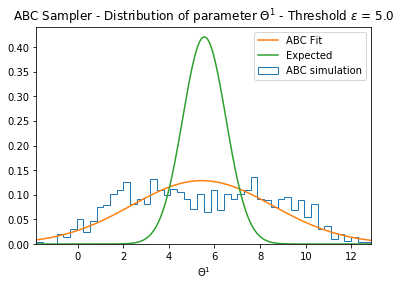

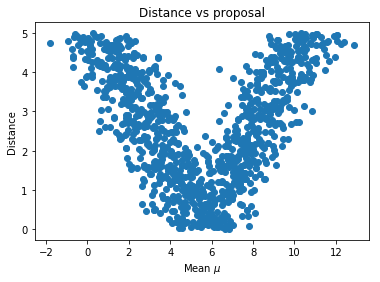

The acceptance rate is:24.366471734892787%
The expected mean is:  5.553942704864362
The expected standard deviation is 0.9487469061633413
The ABC mean is:  5.446724323136949
The ABC standard deviation is 3.100534935486916


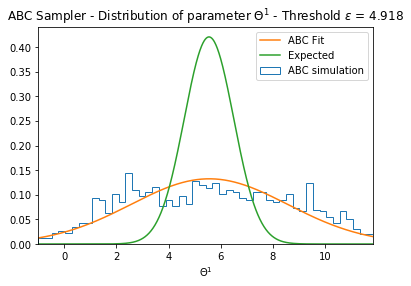

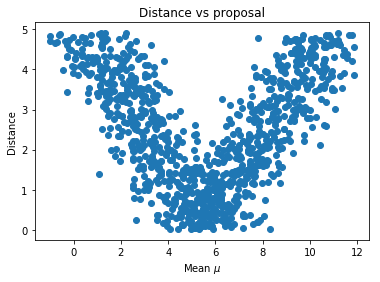

The acceptance rate is:25.106703489831784%
The expected mean is:  5.553942704864362
The expected standard deviation is 0.9487469061633413
The ABC mean is:  5.566241254764753
The ABC standard deviation is 3.0137136524477004


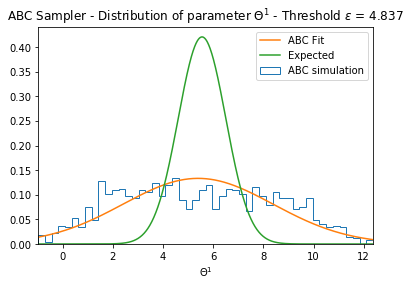

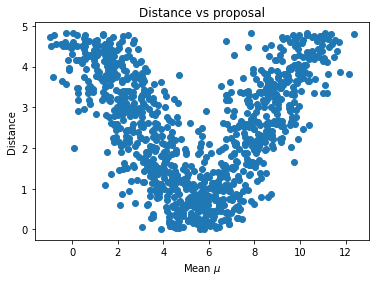

The acceptance rate is:23.1000231000231%
The expected mean is:  5.553942704864362
The expected standard deviation is 0.9487469061633413
The ABC mean is:  5.39608500575704
The ABC standard deviation is 2.9935312152195577


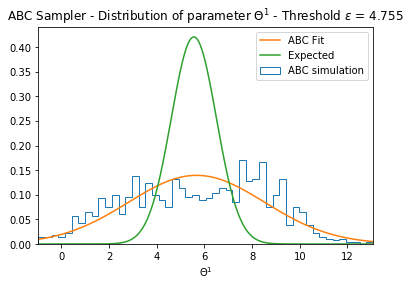

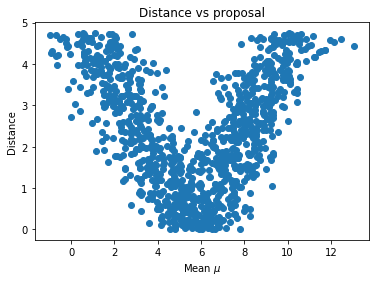

The acceptance rate is:23.849272597185784%
The expected mean is:  5.553942704864362
The expected standard deviation is 0.9487469061633413
The ABC mean is:  5.668404358414487
The ABC standard deviation is 2.861618511127101


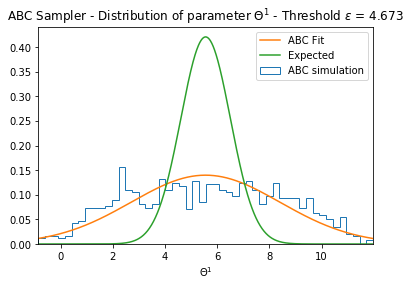

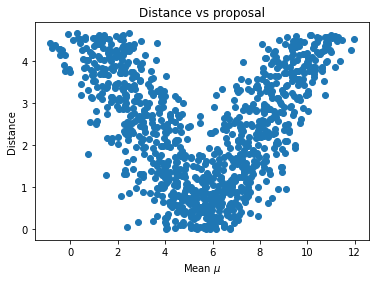

The acceptance rate is:22.33638597274961%
The expected mean is:  5.553942704864362
The expected standard deviation is 0.9487469061633413
The ABC mean is:  5.550876089635678
The ABC standard deviation is 2.854675689046045


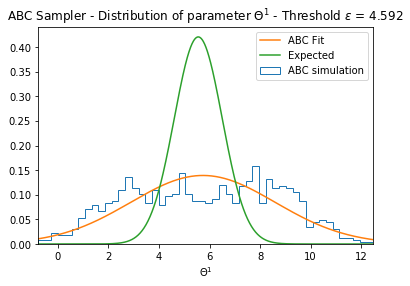

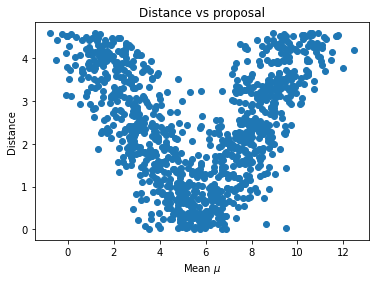

The acceptance rate is:23.05741295826608%
The expected mean is:  5.553942704864362
The expected standard deviation is 0.9487469061633413
The ABC mean is:  5.739405982571458
The ABC standard deviation is 2.8666953545636265


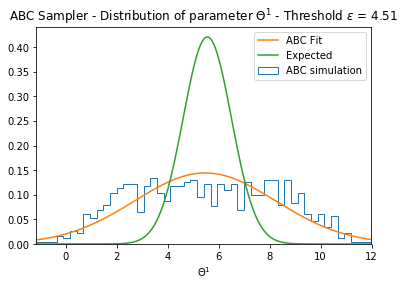

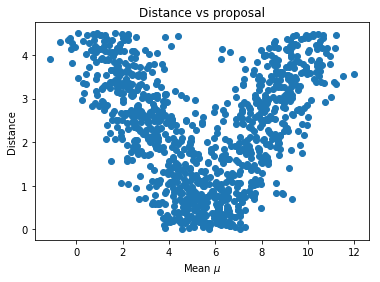

The acceptance rate is:23.014959723820482%
The expected mean is:  5.553942704864362
The expected standard deviation is 0.9487469061633413
The ABC mean is:  5.4705553385177845
The ABC standard deviation is 2.764664515010739


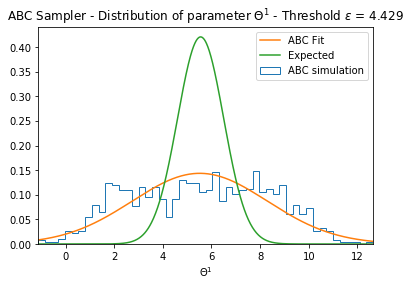

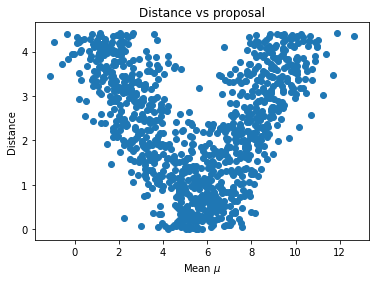

The acceptance rate is:22.48201438848921%
The expected mean is:  5.553942704864362
The expected standard deviation is 0.9487469061633413
The ABC mean is:  5.5179210681778175
The ABC standard deviation is 2.7798522959096292


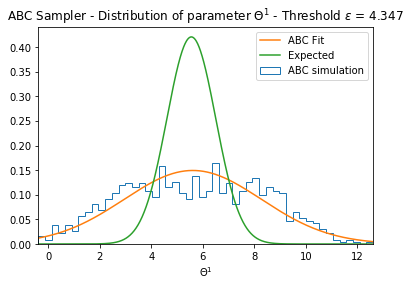

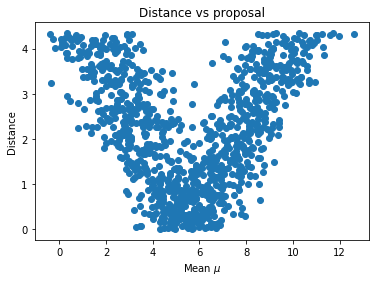

The acceptance rate is:22.271714922049%
The expected mean is:  5.553942704864362
The expected standard deviation is 0.9487469061633413
The ABC mean is:  5.610016033406248
The ABC standard deviation is 2.672026282036649


KeyboardInterrupt: 

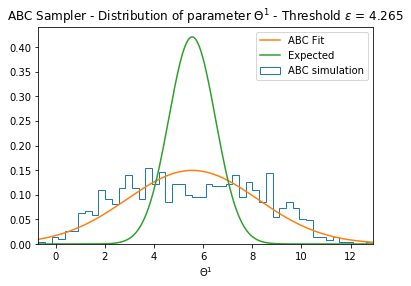

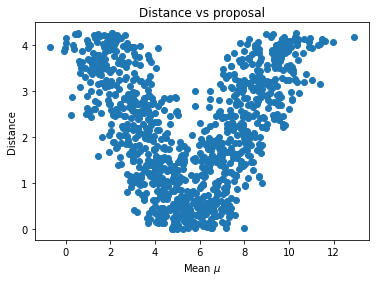

In [7]:
import scipy.stats as stats

data = np.loadtxt('C:\\Users\\tachy\\Desktop\\eth\\stamet\\STAMET_project\\data\\observed_data.txt')

#data = np.random.normal(2,5,200)


def gaussSim(mean, std , N):
    
    samples = np.random.normal(mean, std, N)
    
    return samples

def distance(x, y):
    
    dist = abs(np.mean(x)-np.mean(y))
    
    return dist

def prior(a,b):
    
    prior = np.random.uniform(a,b)
    
    return prior

class ABC(object):
    
    def __init__(self, simulator, data, prior, tresh, dist, N):
        
        self.simulator = simulator
        self.data = data
        self.prior = prior
        self.tresh = tresh
        self.dist = dist
        self.N = N
        self.post = []
        self.dist_array=[]
        self.count = 0
        self.n_iter = len(data)
        self.sigma = 10
        for i in range(0,N):
            
            prop = self.prior(-20,20)
            sim_data = self.simulator(prop,self.sigma,self.n_iter)
            self.count +=1
            distance = self.dist(self.data,sim_data)
            
    
            while distance > tresh:
                
                prop = self.prior(-20,20)
                sim_data = self.simulator(prop,self.sigma,self.n_iter)
                self.count +=1
                distance = self.dist(self.data,sim_data)
                
            self.post.append(prop)
            self.dist_array.append(distance)
            
    
    def GetPost(self):
        return self.post
    
    def GetAcceptance(self):
        return (self.N/self.count)*100
    
    def GetStd(self):
        return np.std(self.post)
        
    def GetPostGraph(self, indices, n_bins, show = True, save = True):
        
        for index in indices:
            to_plot = self.GetPost()
            #mean = np.mean(to_plot)
            #variance = np.var(to_plot)
            coord_max = max(to_plot); coord_min = min(to_plot)
            plt.figure(1)
            n = plt.hist(to_plot, bins = n_bins, histtype = "step",density = 1,label = 'ABC simulation')
            x=np.linspace(coord_min,coord_max,1000)
            mean=np.mean(self.post)
            std=np.std(self.post)
            exp_mean=np.mean(self.data)
            exp_std=np.std(self.data)/np.sqrt(self.n_iter)
            plt.plot(x,stats.norm(loc = mean, scale = std).pdf(x),label = 'ABC Fit')
            plt.plot(x,stats.norm(loc = exp_mean, scale = exp_std).pdf(x),label = 'Expected')
            plt.title("ABC Sampler - Distribution of parameter $\Theta^{" + str(index + 1) + "}$ - Threshold $\u03B5$ = "+str(round(self.tresh,3)))
            plt.xlabel("$\Theta^{" + str(index + 1) + "}$")
            plt.xlim(coord_min, coord_max)
            #plt.xlim(coord_min, coord_max + (coord_max - coord_min)/3.5)
            #plt.text(coord_max - (coord_max - coord_min)/3.5, max(n[0])*0.9, "Number of entries: " + str(N))
            #plt.text(coord_max - (coord_max - coord_min)/3.5, max(n[0])*0.8, "Empirical Mean: " + str(round(mean,3)))
            #plt.text(coord_max - (coord_max - coord_min)/3.5, max(n[0])*0.7, "Empirical Standard Deviation: " + str(round(std,3)))
            plt.legend()
            plt.figure(2)
            plt.scatter(self.post,self.dist_array)
            plt.title("Distance vs proposal")
            plt.xlabel("Mean $\mu$")
            plt.ylabel("Distance")
            
            
            if save:
                plt.savefig(str(index) + ".pdf")
            if show:
                plt.show()
                
N=1000
                
tresh_trial = np.linspace(5,1,50)

accept_array=[]
std_array=[]

for trial in tresh_trial:
    
    
    gauss_ABC = ABC(gaussSim,data,prior,trial,distance,N)
    gauss_ABC.GetPostGraph([0],50)
    print('The acceptance rate is:'+str(gauss_ABC.GetAcceptance())+'%')
    print('The expected mean is: ',np.mean(data))
    print('The expected standard deviation is',np.std(data)/np.sqrt(gauss_ABC.n_iter))
    print('The ABC mean is: ',np.mean(gauss_ABC.GetPost()))
    print('The ABC standard deviation is',np.std(gauss_ABC.GetPost()))
    accept_array.append(gauss_ABC.GetAcceptance())
    std_array.append(gauss_ABC.GetStd())

plt.figure(1)
plt.plot(tresh_trial,accept_array)
plt.title("Acceptance rate vs threshold")
plt.xlabel("Threshold")
plt.ylabel("Acceptance %")
plt.gca().invert_xaxis()
plt.figure(2)
plt.plot(tresh_trial,std_array,label = 'From data')
x=np.linspace(min(tresh_trial),max(tresh_trial),1000)
plt.plot(x,np.sqrt((np.var(data)/gauss_ABC.n_iter)+(x**2/3)),label = 'Expected')
plt.title("Std vs threshold rate")
plt.xlabel("Threshold")
plt.ylabel("Std $\sigma$")
plt.gca().invert_xaxis()
plt.legend()
plt.show()
    


        
        
        
        
        
        

        
        



## 6. ABC for Supernovae Type Ia

In this exercise we will revisit the dark energy measurements from SNe Ia. Instead of running an MCMC, as we did in challenge 6, we will solve the problem with ABC. The goal of this exercise is to build a simulator of the SNLS data and run a simple ABC.

Your tasks are:

* Use the SNLS data from Challenge Lecture 6.      
    
    
* Create a simulator which simulates the data, as a function of $\Omega_{\mathrm{m}}$ and the noise level of the data. Start with uncorrelated noise with the same variance for each redshift. Why does the noise need to be a part of the simulator in the ABC? How is that different from a Likelihood approach? 
Hint: Keep the color, stretch and absolute magnitude nuisance parameters fixed at $\alpha = 1.0, \beta = 2.0$, and $M = 24$ and only vary $\Omega_{m}$ and $\sigma$.


* Calculate the multidimensional ABC constraints on $\Omega_{\mathrm{m}}$ and noise level parameters from the SLNS data using ABC. You can use corner plot to plot your results.
    * Use the distance measure $ d = \sum_{z} | \mu_{observed}(z) - \mu_{simulated}(z) | $
    * You can use the prior range of your choice, but chose it significanly larger than the expected posterior. You can evaluate your simulator as many times as necessary.

C:\Users\tachy\Desktop\eth\stamet\STAMET_project\data\SNLSLikelihoodModule.py:26: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  lcdparams = genfromtxt(snlsdata_path+'snls_3rdyear_lcparams.txt', names = True, dtype=None)


5
10
100
1000


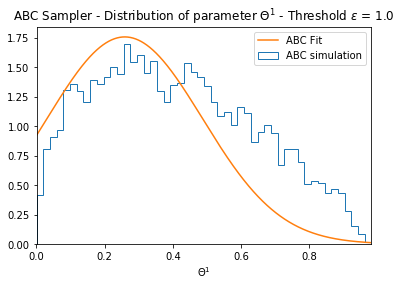

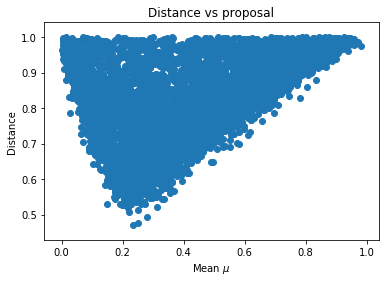

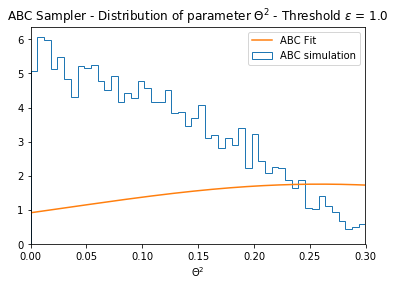

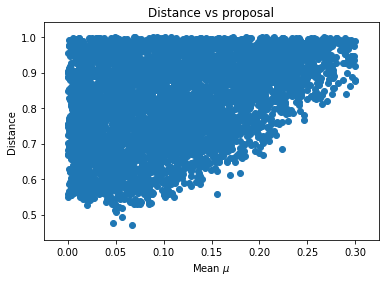

The acceptance rate is:58.75440658049354%
The ABC mean on $\Omega$m is:  0.4083868525506354
The ABC standard deviation $\Omega$m is 0.23105840707831773
The ABC mean on noisestd is:  0.11019298693103784
The ABC standard deviation on noisestd is 0.07401119270576689
5
10
100
1000


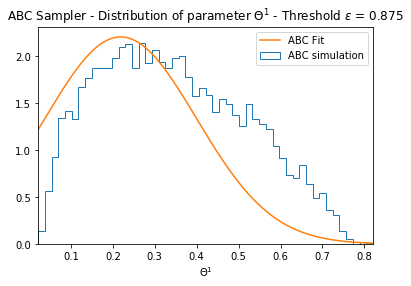

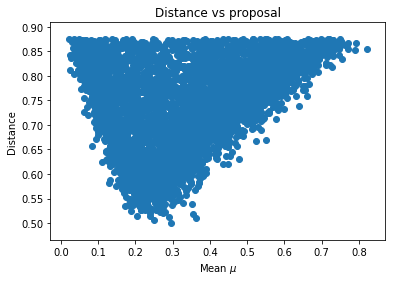

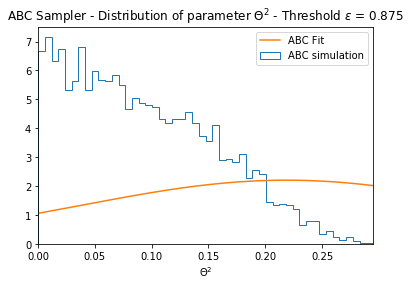

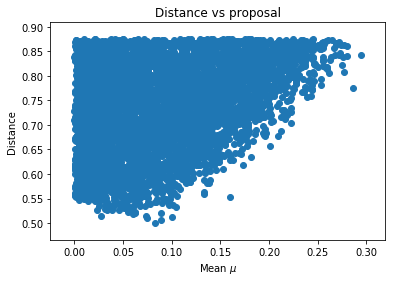

The acceptance rate is:36.42987249544626%
The ABC mean on $\Omega$m is:  0.34417120403966794
The ABC standard deviation $\Omega$m is 0.17281683410752682
The ABC mean on noisestd is:  0.09337360919679906
The ABC standard deviation on noisestd is 0.06377848694328767
5
10
100
1000


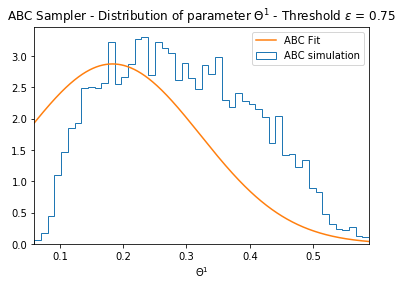

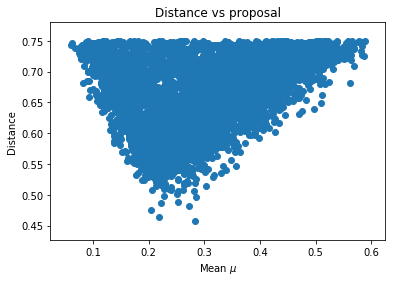

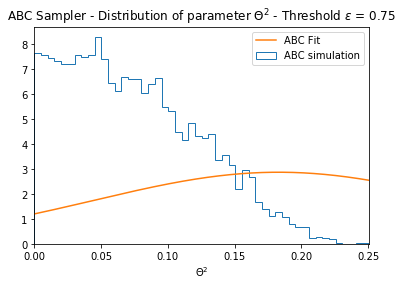

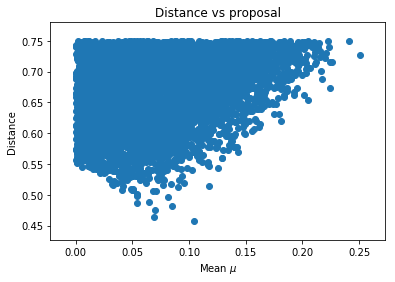

The acceptance rate is:18.167284354334715%
The ABC mean on $\Omega$m is:  0.2909831169697943
The ABC standard deviation $\Omega$m is 0.11246406185936128
The ABC mean on noisestd is:  0.0749890644005453
The ABC standard deviation on noisestd is 0.05001482560744743
5
10
100
1000


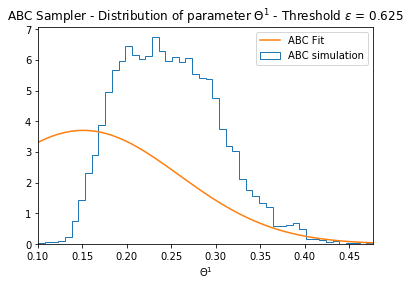

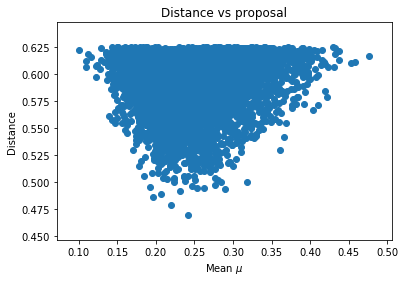

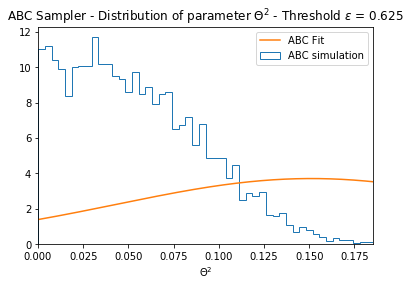

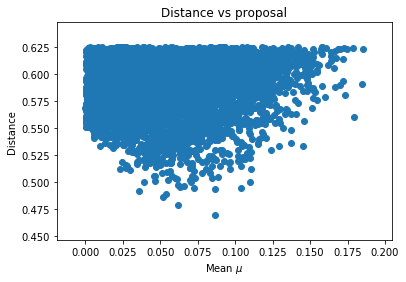

The acceptance rate is:5.066780162542307%
The ABC mean on $\Omega$m is:  0.2479390050663099
The ABC standard deviation $\Omega$m is 0.05615791184145846
The ABC mean on noisestd is:  0.05452690271933027
The ABC standard deviation on noisestd is 0.0367434786069576
5


In [ ]:
import sys
import scipy.stats as stats

snls_class = SNLSLikelihoodModule("C:\\Users\\tachy\\Desktop\\eth\\stamet\\STAMET_project\\data\\")


class SNLSNoise(object):
    
    def __init__(self, snls_class, omegam, noise_std):
        
        
        self.snls = snls_class
        self.omegam = omegam
        self.noise_std = noise_std
        self.alpha = 1.0
        self.beta = 2.0
        self.M = 24
        noise = []
        
        mod_mag = self.snls.getModelMag(self.omegam, self.alpha, self.beta,self.M)
        noise = np.random.normal(loc = 0,scale = noise_std,size = len(mod_mag))
        
        self.mag = mod_mag+noise
        
        
    def getMag(self):
        
        return self.mag
    

def distance(x,y):
    
    #distance = np.sum(np.absolute(x-y))/len(x)
    #distance = np.sum(np.power(x-y,2))/len(x)
    distance = max(np.absolute(x-y))
    
    return distance


def prior(a,b,c,d):
    
    prior_omegam = np.random.uniform(a,b)
    prior_noisestd = np.random.uniform(c,d)
    
    return prior_omegam, prior_noisestd

class ABC(object):
    
    def __init__(self, simulator, data_class, prior, tresh, dist, N):
        
        self.simulator = simulator
        self.data = data_class.lcdparams['mb']
        self.prior = prior
        self.tresh = tresh
        self.dist = dist
        self.N = N
        self.post = []
        self.dist_array=[]
        self.count = 0
        self.count_accept = 0
        self.n_iter = len(self.data)
        self.alpha = 1.0
        self.beta = 2.0
        self.M = 24
        
        for i in range(0,N):
            
            prop = self.prior(0,1,0.0001,0.30)
            sim_data = self.simulator(snls_class,prop[0],prop[1]).getMag()
            self.count +=1
            distance = self.dist(self.data,sim_data)
            
    
            while distance > tresh:
                
                prop = self.prior(0,1,0.0001,0.30)
                sim_data = self.simulator(snls_class,prop[0],prop[1]).getMag()
                self.count +=1
                distance = self.dist(self.data,sim_data)
                #print(distance)
                    
    
            self.post.append(prop)
            self.dist_array.append(distance)
            self.count_accept += 1
            
            
            if (self.count_accept == 5 or self.count_accept == 10 or self.count_accept == 100 or self.count_accept == 1000 or self.count_accept == 10000):
                    
                    print(self.count_accept)
            
    
    def GetPost(self,index):
        return [position[index] for position in self.post]
    
    def GetAcceptance(self):
        return (self.N/self.count)*100
    
    def GetStd(self,index):
        return np.std(np.array([position[index] for position in self.post]))
        
    def GetPostGraph(self, indices, n_bins, show = True, save = True):
        
        for index in indices:
            to_plot = self.GetPost(index)
            #mean = np.mean(to_plot)
            #variance = np.var(to_plot)
            coord_max = max(to_plot); coord_min = min(to_plot)
            plt.figure(1)
            n = plt.hist(to_plot, bins = n_bins, histtype = "step",density = 1,label = 'ABC simulation')
            x=np.linspace(coord_min,coord_max,1000)
            mean=np.mean(self.post)
            std=np.std(self.post)
            #exp_mean=np.mean(self.data)
            #exp_std=np.std(self.data)/np.sqrt(self.n_iter)
            plt.plot(x,stats.norm(loc = mean, scale = std).pdf(x),label = 'ABC Fit')
            #plt.plot(x,stats.norm(loc = exp_mean, scale = exp_std).pdf(x),label = 'Expected')
            plt.title("ABC Sampler - Distribution of parameter $\Theta^{" + str(index + 1) + "}$ - Threshold $\u03B5$ = "+str(round(self.tresh,3)))
            plt.xlabel("$\Theta^{" + str(index + 1) + "}$")
            plt.xlim(coord_min, coord_max)
            #plt.xlim(coord_min, coord_max + (coord_max - coord_min)/3.5)
            #plt.text(coord_max - (coord_max - coord_min)/3.5, max(n[0])*0.9, "Number of entries: " + str(N))
            #plt.text(coord_max - (coord_max - coord_min)/3.5, max(n[0])*0.8, "Empirical Mean: " + str(round(mean,3)))
            #plt.text(coord_max - (coord_max - coord_min)/3.5, max(n[0])*0.7, "Empirical Standard Deviation: " + str(round(std,3)))
            plt.legend()
            plt.figure(2)
            plt.scatter(self.GetPost(index),self.dist_array)
            plt.title("Distance vs proposal")
            plt.xlabel("Mean $\mu$")
            plt.ylabel("Distance")
            
            
            if save:
                plt.savefig(str(index) + ".pdf")
            if show:
                plt.show()
                
N=5000
                
tresh_trial = np.linspace(1,0.5,5)

accept_array=[]
std_array_omegam=[]
std_array_noisevar=[]

for trial in tresh_trial:
    
    
    snls_ABC = ABC(SNLSNoise,snls_class,prior,trial,distance,N)
    snls_ABC.GetPostGraph([0,1],50)
    print('The acceptance rate is:'+str(snls_ABC.GetAcceptance())+'%')
    #print('The expected mean is: ',np.mean(data))
    #print('The expected standard deviation is',np.std(data)/np.sqrt(gauss_ABC.n_iter))
    print('The ABC mean on $\Omega$m is: ',np.mean(snls_ABC.GetPost(0)))
    print('The ABC standard deviation $\Omega$m is',np.std(snls_ABC.GetPost(0)))
    print('The ABC mean on noisestd is: ',np.mean(snls_ABC.GetPost(1)))
    print('The ABC standard deviation on noisestd is',np.std(snls_ABC.GetPost(1)))
    accept_array.append(snls_ABC.GetAcceptance())
    std_array_omegam.append(snls_ABC.GetStd(0))
    std_array_noisevar.append(snls_ABC.GetStd(1))

plt.figure(1)
plt.plot(tresh_trial,accept_array)
plt.title("Acceptance rate vs threshold")
plt.xlabel("Threshold")
plt.ylabel("Acceptance %")
plt.gca().invert_xaxis()
plt.figure(2)
plt.plot(tresh_trial,std_array_omegam,label = 'From data')
#x=np.linspace(min(tresh_trial),max(tresh_trial),1000)
#plt.plot(x,np.sqrt((np.var(data)/gauss_ABC.n_iter)+(x**2/3)),label = 'Expected')
plt.title("Std vs threshold on $\Omega$m")
plt.xlabel("Threshold")
plt.ylabel("Std $\sigma$")
plt.gca().invert_xaxis()
plt.legend()
plt.figure(3)
plt.plot(tresh_trial,std_array_noisevar,label = 'From data')
#x=np.linspace(min(tresh_trial),max(tresh_trial),1000)
#plt.plot(x,np.sqrt((np.var(data)/gauss_ABC.n_iter)+(x**2/3)),label = 'Expected')
plt.title("Std vs threshold on noisevar")
plt.xlabel("Threshold")
plt.ylabel("Std $\sigma$")
plt.gca().invert_xaxis()
plt.legend()
plt.show()
    

